# AI534 Implementation Assignment 3###

**Deadline**: Sunday, Nov. 19, by 11:59pm

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

In this assignment, you will use the sklearn package to experiment with Support Vector Machines and Naive Bayes models. The experiments will utilize the validation data to perform parameter tuning and explore the impact of different parameters on the models' behavior.

You may modify the starter code as you see fit, including changing existing or adding new code blocks. However, please ensure that your modifications are clear so that your TA can easily understand what you are doing and why.

Team 16:
Gowtham Arulmozhi
Suryakrishnan Sathish
Jan Bucher

# New Section

First let's import the packages needed for this assignment.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns


# Data
The data for this assignment consists of a natural language sentiment dataset sourced from Twitter. The first column indicates sentiment of the tweets (zero representing negative sentiment and one for positive sentiment) and the second column contains the text of the tweets.

Two datasets are provided on Canvas: a training set named 'IA3-training.csv' and a validation set named 'IA3-dev.csv'. You will use the training set to build your models and the validation set to tune the parameters and observe their impacts.

Let's load the data.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/AI534/IA3-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = '/content/gdrive/My Drive/AI534/IA3-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_data.head()

,sentiment,text
0,0,@united who is in charge of making decisions o...
1,0,@united great decision making skills flight op...
2,0,@AmericanAir so what if I didn't have the fund...
3,0,@united My flying United is over...sorry. The ...
4,0,@united I believe just customer service. At la...


In [ ]:
train_data.shape, val_data.shape

((9000, 2), (2500, 2))

# Part 0: Preprocessing to form BoW Representation (5 pts)
In this part, you will take the text of the tweets and convert it to the bag-of-words (BoW) representation that can be processed by the model you will train. First, you will build your BoW vocabulary using the training set and represent your training set using *tf-idf*.

Here ***tf*** stands for term frequecy and is defined as follows for a document $d$ and term $t$:

$TF(t,d) = \frac{\mbox{Num. of times } t \mbox{ appears in } d}{\mbox{Total number of terms in }d}$

and ***idf*** stands for inverse document frequency and is defined as follows for a term $t$ and a document collection $D$

$IDF(t, D) = \log(\frac{N}{|\{d\in D: t\in d\}|}) $


where $N$ is the total number of documents in $D$, and $|\{d\in D: t\in d\}|$ is the number of documents that contain term $t$.


Specifically, you will be using the **TfidfVectorizer** class from the sklearn.feature_extraction.text package (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#). For this assignment, you should set '***stop_words=english***', other parameters can remain at their default values.

The specific methods you will need to use include:

*   ***fit_transform()***:  You will apply this function to the training text to learn the vocabulary and the inverse document frequency, and generate the tf-idf representation for the training documents.

*   ***transform()***: you will apply this function to the validation text to generate the tf-idf representation for the validation documents, using a vocabulary and inverse document frequency that are already learned from the training data.

Note that both of the above methods return a sparse matrix representation of the documents. This format can be directly used by the SVM package and the Naive Bayes Package for learning. Using a sparse matrix for your document representation is computationally much more efficient, especially for SVM models.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvec = TfidfVectorizer(stop_words='english')
text_vec = tfidfvec.fit_transform(train_data['text'])
train_data['text_vec'] = list(text_vec)

text_vec_val = tfidfvec.transform(val_data['text'])
val_data['text_vec'] = list(text_vec_val)

In [ ]:
# Assuming you have a 'label' column indicating positive/negative sentiment
positive_data = train_data[train_data['sentiment'] == 1]
negative_data = train_data[train_data['sentiment'] == 0]

# Function to get top N words from a TF-IDF matrix
def get_top_words(tfidf_matrix, n=20):
    feature_names = tfidfvec.get_feature_names_out()
    top_words_idx = tfidf_matrix.sum(axis=0).argsort()[:, ::-1][:, :n]
    top_words = [feature_names[idx] for idx in top_words_idx.flat]
    return top_words

top_positive_words = get_top_words(text_vec[positive_data.index])
top_negative_words = get_top_words(text_vec[negative_data.index])

common_words = set(top_positive_words).intersection(set(top_negative_words))

print("Top 20 words for positive category:", top_positive_words)
print("Top 20 words for negative category:", top_negative_words)
print("Common words:", common_words)


Top 20 words for positive category: ['thanks', 'thank', 'jetblue', 'southwestair', 'united', 'americanair', 'great', 'usairways', 'flight', 'virginamerica', 'http', 'love', 'just', 'awesome', 'best', 'guys', 'service', 'good', 'got', 'appreciate']
Top 20 words for negative category: ['flight', 'united', 'usairways', 'americanair', 'southwestair', 'jetblue', 'cancelled', 'service', 'hold', 'hours', 'help', 'customer', 'just', 'time', 'delayed', 'plane', 'flightled', 'hour', 'bag', 'amp']
Common words: {'americanair', 'service', 'flight', 'usairways', 'southwestair', 'just', 'united', 'jetblue'}


In [ ]:
X_train = text_vec
y_train = train_data['sentiment'].ravel()
X_test = text_vec_val
y_test = val_data['sentiment'].ravel()

In [ ]:
X_train[0]

<1x10748 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9000, 10748), (9000,), (2500, 10748), (2500,))

**Question**
1. Examine the types of words present in each of the three categories: 'common', 'positive', and 'negative'. Describe the nature and characteristics of these words.
2. Reflect on how a linear classification model might utilize the words from each category. What are your expectations regarding the sign (positive or negative) and magnitude (size) of the weights that would be assigned to these words by the model?

**Answers** :

1)

In each of the three categories different airlines' names are present, which makes sense since the given documents (tweets) are addressed to different American airlines. Also, the words "service" and "flight" are present in all categories, which makes sense when the tweets mainly rate customer experiences with the airlines. "Just" is a word which is generally very common and which can be found in all three categories too. Additionally, in the positive category there is a bunch of words expressing appreciation and satisfaction like "thanks" or "awesome" whereas the negative category contains some terms related to problems, especially time-related like "delayed" or "hours", and others used in expressing complaints about sources of dissatisfaction like "plane" or bag".

2)

Words only present in the positive category like 'thanks', 'thank', 'great', 'awesome', 'best', etc., are likely to have positive weights, whereas words only present in the negative category are likely to have negative weights. The magnitude depends on how strongly these words correlate with a positive/negative sentiment. The more indicative of a positive/negative sentiment a word is, the higher its positive/negative weight might be. However, something which should be considered here is the fact that positive associated words could also be used in sarcastic comments, expressing anger and dissatisfaction (e.g.: "@United I loved flying with you, my flight was delayed by only 4 hours..."). Thus I expect the absolute value of unambiguously negative words in the negative category like "delayed" to have slightly higher weights then their positive counterparts.

In contrast, the words in the common category are unlikely to be used at all in classification, since they provide no piece of advice as to which category the tweet falls into. Thus, the magnitude of the weights assigned to these words are expected to be very low or zero.


# Part 1. (30 pts) Linear SVM.
Use sklearn to train linear SVMs and tune the hyperparameter $c$ using grid search, considering $c = 10^i$ with $i$ ranging from -3 to 3, based on the validation accuracy. For each $c$ value, please
1. build a linear SVM model using the svm.SVC class
2. record the total number of support vectors of your model
3. evaluate the model's accuracy on the training data and validation data respectively.


Please produce the following two plots:
1.   Accuracy vs. $c$. In this plot, please plot both the training and validation accuracy as a function of the $c$ parameter (using log scale for $c$)
2.   Number of support vectors vs. $c$. In this plot, please plot the # of total support vectors for your SVM mdoel as a function of the $c$ parameter (using log scale for $c$).

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

C_values = [10**i for i in range(-3, 4)]

training_accuracies = []
validation_accuracies = []
num_support_vectors = []

for C in C_values:

    model = svm.SVC(kernel='linear', C=C)

    model.fit(X_train, y_train)

    # Record the number of support vectors
    num_sv = np.sum(model.n_support_)
    num_support_vectors.append(num_sv)

    # Evaluate the model on training data
    y_train_pred = model.predict(X_train)
    training_acc = accuracy_score(y_train, y_train_pred)
    training_accuracies.append(training_acc)

    # Evaluate the model on validation data
    y_val_pred = model.predict(X_test)
    val_acc = accuracy_score(y_test, y_val_pred)
    validation_accuracies.append(val_acc)


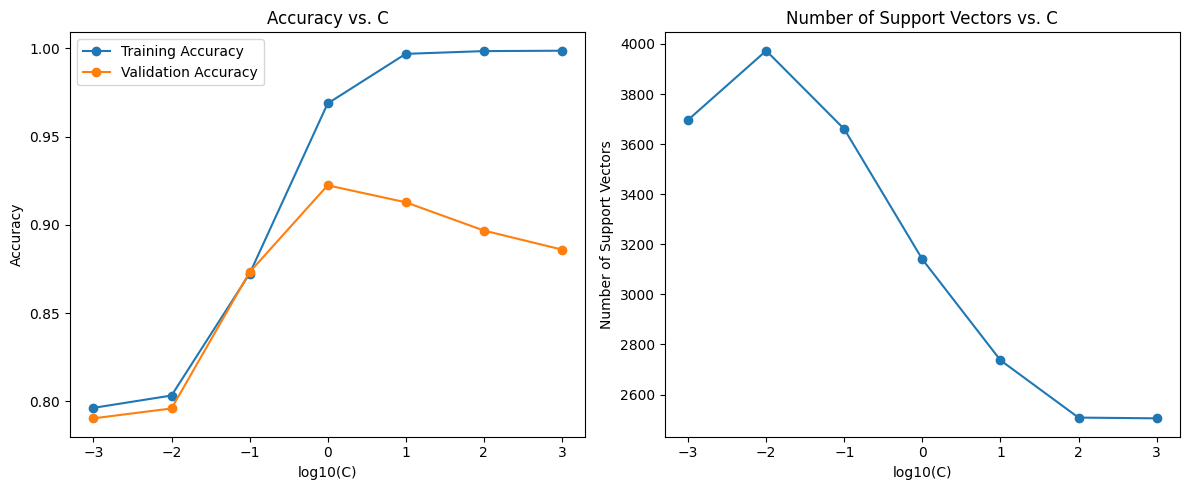

In [ ]:
# Plotting the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy vs C
ax1.plot(np.log10(C_values), training_accuracies, label='Training Accuracy', marker='o')
ax1.plot(np.log10(C_values), validation_accuracies, label='Validation Accuracy', marker='o')
ax1.set_xlabel('log10(C)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs. C')
ax1.legend()

# Plot Number of Support Vectors vs C
ax2.plot(np.log10(C_values), num_support_vectors, marker='o')
ax2.set_xlabel('log10(C)')
ax2.set_ylabel('Number of Support Vectors')
ax2.set_title('Number of Support Vectors vs. C')

# Show the plots
plt.tight_layout()
plt.show()

**Question**
1. What trend do you theoretically expect to see for training and validation performance as we increase $c$? Why? Does the observed behavior match your expectation? If not, can you provide some explanation?
2. What trend do you theoretically expect to see for the number of support vectors as we increase $c$? Why? Does the observed behavior match your expectation? If not, can you provide some explanation?  

**Answers:**

1)

Larger c values lead to a bigger penalty for errors (-> points having a functional margin smaller than 1). Thus, the optimal solution focuses more on separating training points correctly than making the decision boundary as "fat" as possible. This leads to overfitting to the training data.
Hence, when increasing the value of C we expect the training accuracy to rise, since the model can fit the training data better and better. In contrast, we expect the validation accuracy to get worse with increasing c values, because of the mentioned phenomenon of overfitting.

The observed behavior for the training data matches our expectations. For the validation data however, the accuracy first increases as we increase c (before it starts decreasing after some c value). This is probably due to the fact, that the smallest C values are so small, that the model becomes too tolerant of misclassifying training instances and fails to capture the underlying patterns in the training data. This leads to underfitting, the model does not perform well on both the training and validation data.

2)

All points with a functional margin of 1 or smaller than 1 are called support vectors. For larger values of c the model becomes less tolerant of misclassifying data points. This leads to less points with a functional margin smaller than 1.  Thus, we expect the number of support vectors to decrease as we increase c.

The observations meet our expectations, apart from the first to the second c value. We cannot provide an explanation for this growth.


Expand your search beyond the grid search for the parameter $c$.
Here is the basic instruction:
* **Boundary Expansion**: If the best-performing parameter choice is located at the edge of your current grid search range, extend this boundary outward. This approach helps to explore whether even better-performing parameters exist beyond the existing limits of your grid.

* **Grid Refinement for Central Optima**: When the optimal parameter choice lies within the middle of your search grid, focus on refining the grid around this optimum. For instance, if your current best result is at $i=1$, consider adding intermediate points near the current best such as $i=0.5$ and $1.5$ to your search. This targeted refinement helps in achieving a more precise determination of the optimum within the identified range.

Additionally, it's important to apply these strategies iteratively as needed. If subsequent searches reveal new boundaries or central optima, repeat the expansion or refinement process to continually hone in on the most effective parameters.



In [ ]:
best_accuracy_initial = 0
best_C_initial = None
best_accuracy = 0
best_C = None

C_values = np.logspace(-3, 3, 7)
for C in C_values:
    model = svm.SVC(kernel='linear', C=C)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_test)
    val_acc = accuracy_score(y_test, y_val_pred)

    # Check if this is the best accuracy
    if val_acc > best_accuracy_initial:
        best_accuracy_initial = val_acc
        best_C_initial = C

print("Initial Best C is ",best_C_initial)
print("Initial Best Score is ",best_accuracy_initial)

if best_C_initial == min(C_values) or best_C_initial == max(C_values):
    if best_C_initial == min(C_values):
        Expanded_C_values = np.logspace(np.log10(best_C_initial)-1, np.log10(best_C_initial), 3)
    else:
        Expanded_C_values = np.logspace(np.log10(best_C_initial), np.log10(best_C_initial)+1, 3)

    for C in Expanded_C_values:
        model = svm.SVC(kernel='linear', C=C)
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_test)
        val_acc = accuracy_score(y_test, y_val_pred)

        # Check if this is the best accuracy
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_C = C
else:
    i = np.log10(best_C_initial)
    Refined_C_values = np.logspace(i-0.5, i+0.5, 5)
    for C in Refined_C_values:
        model = svm.SVC(kernel='linear', C=C)
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_test)
        val_acc = accuracy_score(y_test, y_val_pred)

        # Check if this is the best accuracy
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_C = C

print("Best C:", best_C)
print("Best Accuracy:", best_accuracy)

final_model = svm.SVC(kernel='linear', C=best_C)
final_model.fit(X_train, y_train)
num_sv = np.sum(final_model.n_support_)
num_support_vectors.append(num_sv)
print(f"Final Model Number of Support Vectors: {num_support_vectors}")
# Evaluate the model on training data
y_train_pred = final_model.predict(X_train)
training_acc = accuracy_score(y_train, y_train_pred)
training_accuracies.append(training_acc)
print(f"Final Training Accuracy for {best_C} is: {training_acc}")

# Evaluate the model on validation data
y_val_pred = final_model.predict(X_test)
val_acc = accuracy_score(y_test, y_val_pred)
validation_accuracies.append(val_acc)
print(f"Final Validation Accuracy for {best_C} is: {val_acc}")

Initial Best C is  1.0
Initial Best Score is  0.9224
Best C: 1.7782794100389228
Best Accuracy: 0.9252
Final Model Number of Support Vectors: [3697, 3973, 3660, 3140, 2737, 2508, 2505, 3046]
Final Training Accuracy for 1.7782794100389228 is: 0.9832222222222222
Final Validation Accuracy for 1.7782794100389228 is: 0.9252


**Question:**
What is the best validation performance you are able to achieve using linear SVM on this dataset? What $c$ value is used?

**Answer:** The best validaton accuracy we are able to achieve using linear SVM is 92.5%. It is acheived by using c=~1.78.

For the best performing linear SVM model that you built, identify and report the ten words with the highest positive weight coefficients and the ten words with the highest negative weight coefficients, separately.

In [ ]:
feature_names = tfidfvec.get_feature_names_out()
coefficients = final_model.coef_.toarray().flatten()
top_positive_indices = coefficients.argsort()[-10:][::-1]
top_negative_indices = coefficients.argsort()[:10]

top_positive_words = [feature_names[i] for i in top_positive_indices]
top_negative_words = [feature_names[i] for i in top_negative_indices]

common_words = set(top_positive_words).intersection(set(top_negative_words))

print("Top 10 words for positive category:", top_positive_words)
print("Top 10 words for negative category:", top_negative_words)
print("Common words:", common_words)

Top 10 words for positive category: ['thank', 'thanks', 'awesome', 'great', 'kudos', 'love', 'excellent', 'amazing', 'best', 'appreciate']
Top 10 words for negative category: ['worst', 'hold', 'hours', 'hour', 'website', 'luggage', 'delayed', 'paid', 'delay', 'sit']
Common words: set()


# Part 2. (35 pts) SVM with RBF kernel

Use sklearn to train SVMs with RBF kernel and tune the hyperparameters $c$ and $\gamma$ ($\gamma=1/\sigma^2$ in the RBF kernel definition provided in the lecture slides) using grid search based on the validation accuracy. For $c$, please search over $c = 10^i$ with $i$ ranging from $-3$ to $3$. For $\gamma$, please search over $\gamma=10^{-i}$ with $i$ ranging from -3 to 1.  For each $c$ and $\gamma$ value combination, please
1. build a SVM model using the svm.SVC class with kernel="rbf"
2. record the total number of support vectors of your model
3. evaluate the model's accuracy on the training data and validation data respectively.


Please plot the training accuracy, validation accuracy, and the number of support vectors as function of $c$ and $\gamma$ using the heatmap function from the seaborn package (https://seaborn.pydata.org/generated/seaborn.heatmap.html). Please use 'annot=True' and specify appropriate format to ensure the annotation can be easily read on the heatmap.


In [ ]:
# Define the range of hyperparameter values
param_grid = {'C': np.logspace(-3, 3, 7),
              'gamma': np.logspace(-3, 1, 5)}

# Initialize empty DataFrames to store results
results_df = pd.DataFrame(columns=['C', 'gamma', 'Train Accuracy', 'Validation Accuracy', 'Num Support Vectors'])

# Perform grid search
for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        # Build SVM model with RBF kernel
        model = svm.SVC(kernel='rbf', C=C, gamma=gamma)
        model.fit(X_train, y_train)

        # Record the number of support vectors
        num_sv = np.sum(model.n_support_)

        # Evaluate the model on training data
        y_train_pred = model.predict(X_train)
        train_acc = accuracy_score(y_train, y_train_pred)

        # Evaluate the model on validation data
        y_val_pred = model.predict(X_test)
        val_acc = accuracy_score(y_test, y_val_pred)

        results_df = pd.concat([results_df, pd.DataFrame({'C': C, 'gamma': gamma,
                                                          'Train Accuracy': train_acc,
                                                          'Validation Accuracy': val_acc,
                                                          'Num Support Vectors': num_sv}, index=[0])], ignore_index=True)
results_df

,C,gamma,Train Accuracy,Validation Accuracy,Num Support Vectors
0,0.001,0.001,0.796333,0.7904,3666
1,0.001,0.010,0.796333,0.7904,3666
2,0.001,0.100,0.796333,0.7904,3666
3,0.001,1.000,0.796333,0.7904,3677
4,0.001,10.000,0.796333,0.7904,3745
5,0.010,0.001,0.796333,0.7904,3666
6,0.010,0.010,0.796333,0.7904,3666
7,0.010,0.100,0.796333,0.7904,3818
8,0.010,1.000,0.796333,0.7904,4645
9,0.010,10.000,0.796333,0.7904,8937


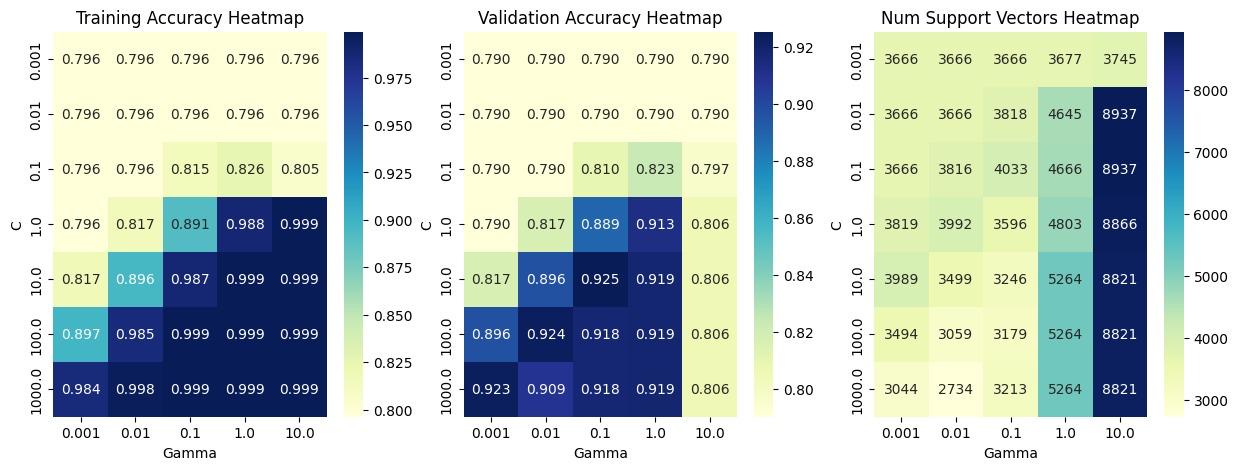

In [ ]:
heatmap_data_train = results_df.pivot(index='C', columns='gamma', values='Train Accuracy')
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
sns.heatmap(heatmap_data_train, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Training Accuracy Heatmap')
plt.xlabel('Gamma')
plt.ylabel('C')

plt.subplot(1, 3, 2)
heatmap_data_val = results_df.pivot(index='C', columns='gamma', values='Validation Accuracy')
sns.heatmap(heatmap_data_val, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Validation Accuracy Heatmap')
plt.xlabel('Gamma')
plt.ylabel('C')

results_df['Num Support Vectors'] = pd.to_numeric(results_df['Num Support Vectors'], errors='coerce')
plt.subplot(1, 3, 3)
heatmap_data_sv = results_df.pivot(index='C', columns='gamma', values='Num Support Vectors')
sns.heatmap(heatmap_data_sv, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Num Support Vectors Heatmap')
plt.xlabel('Gamma')
plt.ylabel('C')

plt.show()

**Question**
1. From a theoretical perspective, how would you expect the parameters $c$ and $\gamma$ to influence the model's ability to overfit to the training data? Based on this perspective, how would you expect the training accuracy to change as you change $c$ (keeping $\gamma$ constant), and as you change $\gamma$ (keeping $c$ constant)? Are there any discrepancies between the expected and observed trends? If so, provide some possible explanations for the discrepancies.

2. Similarly, how would you expect the validation accuracy to change as you change $c$ (keeping $\gamma$ constant) and as you change $\gamma$ (keeping $c$ constant)? Are there any discrepancies between the expected and observed trends? If so, please provide some possible explanations for the differences.

3. From a theoretical perspective, how would you expect the parameters $c$ and $\gamma$ influence the number of support vectors? Are there any discrepencies between the expected and observed trends?  If so, provide some possible explanations for the differences.

**Your answer goes here**

*Answer*

1. From a theoretical standpoint, higher values of $c$ in the SVM model lead to a narrower margin and increased sensitivity to misclassifications, potentially resulting in overfitting to the training data. Conversely, larger $\gamma$ values contribute to more intricate decision boundaries, also increasing the risk of overfitting. As $c$ increases, training accuracy tends to rise, as the model becomes less tolerant of misclassifications. Similarly, larger $\gamma$ values may result in higher training accuracy due to a more flexible decision boundary. Discrepancies may arise when overfitting occurs with excessively high $c$ or $\gamma$, leading to a decrease in training accuracy.

2. Theoretical expectations suggest that overly high values of $c$ or $\gamma$ may lead to overfitting, resulting in lower validation accuracy. An optimal $c$ should generalize well to unseen data, and smaller $\gamma$ values might contribute to better generalization. Discrepancies between expected and observed trends may occur when the chosen $c$ or $\gamma$ values are not conducive to good generalization, causing the model to perform poorly on validation data.

3. Theoretical considerations posit that smaller $c$ values allow more training points to be considered as support vectors, leading to a larger count. Larger $c$ values, enforcing a narrower margin, might result in fewer support vectors. Similarly, smaller $\gamma$ values contribute to a smoother decision boundary with more support vectors, while larger $\gamma$ values can lead to a more complex boundary with fewer support vectors. Discrepancies may arise if the dataset characteristics or noise levels impact the expected relationship between $c$, $\gamma$, and the number of support vectors.


Expand your search using the strategy introduced in part 1 to search for the $c$ and $\gamma$ values that leads to the highest validation accuracy on this data set. Please report the best validation accuracy you achieve and the corresponding $c$ and $\gamma$ values used.

In [ ]:
best_accuracy_initial = 0
best_params_initial = {'C': None, 'gamma': None}
best_accuracy = 0
best_params = {'C': None, 'gamma': None}

C_values = np.logspace(-3, 3, 7)
gamma_values = np.logspace(-3, 1, 5)

for C in C_values:
  for gamma in gamma_values:
    model = svm.SVC(kernel='rbf', C=C, gamma=gamma)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_test)
    val_acc = accuracy_score(y_test, y_val_pred)

    # Check if this is the best accuracy
    if val_acc > best_accuracy_initial:
        best_accuracy_initial = val_acc
        best_params_initial['C'] = C
        best_params_initial['gamma'] = gamma

print("Initial Best params is ",best_params_initial)
print("Initial Best Score is ",best_accuracy_initial)

best_C = best_params_initial['C']
best_gamma = best_params_initial['gamma']



# Adjust C boundaries
if best_C == min(C_values):
    if True:
        best_C_values = np.logspace(np.log10(best_C)-1, np.log10(best_C), num=3)
    else:
        best_C_values = np.logspace(-np.log10(best_C)-1, -np.log10(best_C), num=3)
elif best_C == max(C_values):
    if True:
        best_C_values = np.logspace(np.log10(best_C), np.log10(best_C)+1, num=3)
    else:
        best_C_values = np.logspace(-np.log10(best_C), -np.log10(best_C)+1, num=3)
else:  # Grid Refinement
    i = np.log10(best_C) if True else -np.log10(best_C)
    best_C_values = np.logspace(i-0.5, i+0.5, num=5)


# Adjust gamma boundaries
if best_gamma == min(gamma_values):
    if True:
        best_gamma_values = np.logspace(np.log10(best_gamma)-1, np.log10(best_gamma), num=3)
    else:
        best_gamma_values = np.logspace(-np.log10(best_gamma)-1, -np.log10(best_gamma), num=3)
elif best_gamma == max(gamma_values):
    if True:
        best_gamma_values = np.logspace(np.log10(best_gamma), np.log10(best_gamma)+1, num=3)
    else:
        best_gamma_values = np.logspace(-np.log10(best_gamma), -np.log10(best_gamma)+1, num=3)
else:  # Grid Refinement
    i = np.log10(best_gamma) if True else -np.log10(best_gamma)
    best_gamma_values = np.logspace(i-0.5, i+0.5, num=5)

print("Adjusted C Values:", best_C_values)
print("Adjusted Gamma Values:", best_gamma_values)


Initial Best params is  {'C': 10.0, 'gamma': 0.1}
Initial Best Score is  0.9252
Adjusted C Values: [ 3.16227766  5.62341325 10.         17.7827941  31.6227766 ]
Adjusted Gamma Values: [0.03162278 0.05623413 0.1        0.17782794 0.31622777]


In [ ]:
for C in best_C_values:
  for gamma in best_gamma_values:
    model = svm.SVC(kernel='rbf', C=C, gamma=gamma)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_test)
    val_acc = accuracy_score(y_test, y_val_pred)

    # Check if this is the best accuracy
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_params['C'] = C
        best_params['gamma'] = gamma

print("Best params is ",best_params)
print("Best Accuracy is ",best_accuracy)

Best params is  {'C': 5.623413251903491, 'gamma': 0.1778279410038923}
Best Accuracy is  0.9272


# Part 3: (30 pts) Naive Bayes Classifier

In this part, you will use the same TF-IDF representation of the documents and experiment with MultiNomial Naive Bayes classifier to tune the smoothing parameter $\alpha$. Please consider the following initial values for $\alpha$: [2, 1, 0.5, 0.1, 0.05, 0.01]

For each of the $\alpha$ value, please
1. build a multinomial Naive Bayes model using the MultinomialNB class in the sklearn.naive_bayes package
2. evaluate the model's accuracy on the training data and validation data respectively.

For results, please
1. plot the training and validation accuracy as a function of $\alpha$ (using log scale).
2. print out the best training accuracy with its corresponding $\alpha$ and the best validation accuracy with its corresponding $\alpha$.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
aValue = [2, 1, 0.5, 0.1, 0.05, 0.01]
train_acc = []
val_acc = []
for a in aValue:
    mnbModel = MultinomialNB(alpha=a)
    mnbModel.fit(X_train, y_train)

    y_train_pred = mnbModel.predict(X_train)
    training_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc.append(training_accuracy)
    print(f"Training Accuracy for {a} is: {training_accuracy}")

    # Evaluate the model on validation data
    y_val_pred = mnbModel.predict(X_test)
    val_accuracy = accuracy_score(y_test, y_val_pred)
    val_acc.append(val_accuracy)
    print(f"Validating Accuracy for {a} is: {val_accuracy}")

Training Accuracy for 2 is: 0.8247777777777778
Validating Accuracy for 2 is: 0.812
Training Accuracy for 1 is: 0.8728888888888889
Validating Accuracy for 1 is: 0.8332
Training Accuracy for 0.5 is: 0.9215555555555556
Validating Accuracy for 0.5 is: 0.8604
Training Accuracy for 0.1 is: 0.9617777777777777
Validating Accuracy for 0.1 is: 0.8892
Training Accuracy for 0.05 is: 0.9664444444444444
Validating Accuracy for 0.05 is: 0.8892
Training Accuracy for 0.01 is: 0.9717777777777777
Validating Accuracy for 0.01 is: 0.8848


In [ ]:
train_acc

[0.8247777777777778,
 0.8728888888888889,
 0.9215555555555556,
 0.9617777777777777,
 0.9664444444444444,
 0.9717777777777777]

In [ ]:
val_acc

[0.812, 0.8332, 0.8604, 0.8892, 0.8892, 0.8848]

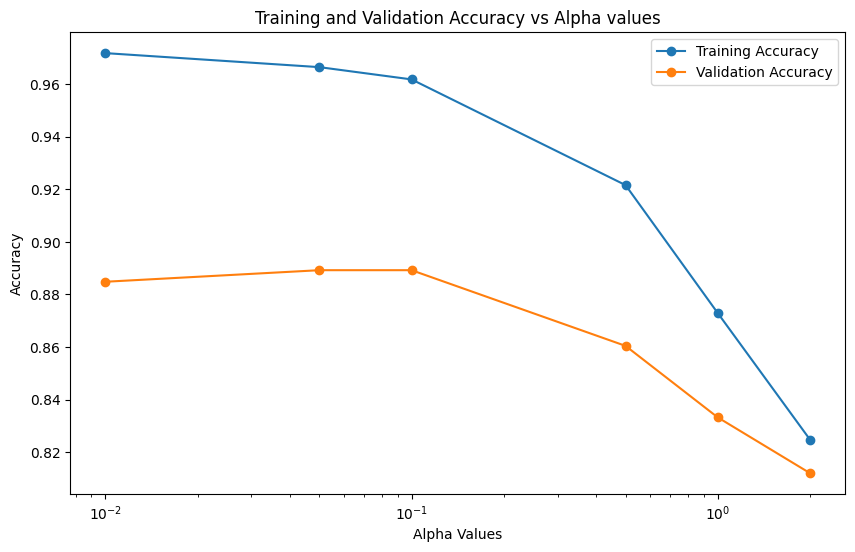

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(aValue, train_acc, label='Training Accuracy', marker='o')
plt.plot(aValue, val_acc, label='Validation Accuracy', marker='o')
plt.xscale('log')
plt.xlabel('Alpha Values')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Alpha values')
plt.legend()
plt.show()

In [ ]:
best_train_a = aValue[np.argmax(train_acc)]
best_val_a = aValue[np.argmax(val_acc)]
print("Best Training Accuracy:", max(train_acc))
print("Alpha:",best_train_a)
print("Best Validation Accuracy:", max(val_acc))
print("Alpha", best_val_a)

Best Training Accuracy: 0.9832222222222222
Alpha: 2
Best Validation Accuracy: 0.8892
Alpha 0.1


**Question**
Theoretically, how do you expect changing the $\alpha$ parameter influence overfitting for Naive Bayes model?
Based on this perspective, how do you expect the training and validation accuracy to change as we change $\alpha$? Are there any discrepancies between the expected and observed trends? If so, can you propose some possible explanations for these differences?

**Your answer goes here**

*Answer:*

The parameter $\alpha$ in the Naive Bayes model corresponds to the Laplace smoothing factor and plays a crucial role in handling unseen features in the training data. Theoretically, adjusting $\alpha$ influences overfitting; smaller values result in less smoothing, making the model more prone to overfitting on the training data, especially when dealing with sparse features. Conversely, larger $\alpha$ values increase smoothing, reducing the risk of overfitting but potentially leading to underfitting. As $\alpha$ decreases, training accuracy may rise due to the model fitting the training data more closely. However, overly small $\alpha$ values may lead to poor generalization, resulting in lower validation accuracy. Discrepancies between expected and observed trends might occur when the chosen $\alpha$ value is suboptimal for balancing overfitting and underfitting, possibly due to data characteristics or noise levels impacting the model's performance.

Expand your search using the strategy introduced in part 1 to search for the $\alpha$ that leads to the highest validation accuracy on this data set.
Please report the best validation accuracy you achieve and the corresponding $\alpha$ value used.

In [ ]:
def train_eval_model(alpha, X_train, y_train, X_val, y_val):
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = accuracy_score(y_val, model.predict(X_val))
    return train_acc, val_acc

In [ ]:
alpha_values = [2, 1, 0.5, 0.1, 0.05, 0.01]
train_accuracies = []
val_accuracies = []

for alpha in alpha_values:
    train_acc, val_acc = train_eval_model(alpha, X_train, y_train, X_test, y_test)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

best_alpha_idx = np.argmax(val_accuracies)
best_alpha = alpha_values[best_alpha_idx]

if best_alpha_idx == 0 or best_alpha_idx == len(alpha_values) - 1:
    # Boundary value - expand the search
    if best_alpha_idx == 0:
        refined_alphas = np.linspace(alpha_values[0]/10, alpha_values[0], 5)
    else:
        refined_alphas = np.linspace(alpha_values[-1], alpha_values[-1]*10, 5)
else:
    # Inner value - refine the search
    refined_alphas = np.linspace(alpha_values[best_alpha_idx - 1], alpha_values[best_alpha_idx + 1], 5)

refined_train_accuracies = []
refined_val_accuracies = []
for alpha in refined_alphas:
    train_acc, val_acc = train_eval_model(alpha, X_train, y_train, X_test, y_test)
    refined_train_accuracies.append(train_acc)
    refined_val_accuracies.append(val_acc)

best_refined_alpha_idx = np.argmax(refined_val_accuracies)
best_refined_alpha = refined_alphas[best_refined_alpha_idx]
best_refined_val_acc = refined_val_accuracies[best_refined_alpha_idx]

print(f"Best Validation Accuracy from refined search: {best_refined_val_acc:.4f}")
print(f"Corresponding alpha: {best_refined_alpha}")

Best Validation Accuracy from refined search: 0.8892
Corresponding alpha: 0.05


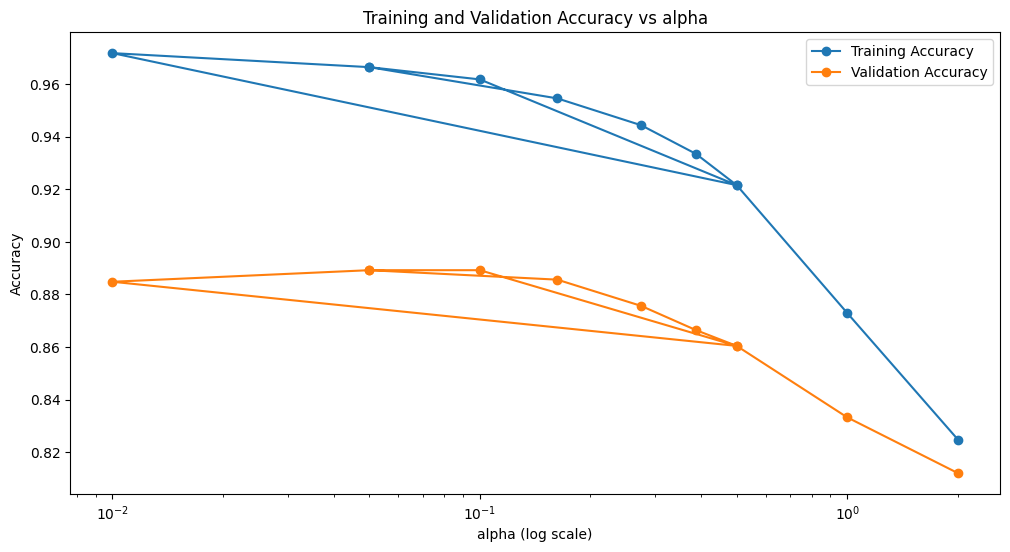

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(alpha_values + list(refined_alphas), train_accuracies + refined_train_accuracies, label='Training Accuracy', marker='o')
plt.plot(alpha_values + list(refined_alphas), val_accuracies + refined_val_accuracies, label='Validation Accuracy', marker='o')
plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs alpha')
plt.legend()
plt.show()

As discussed in class, the multinomial naive bayes classifier learns a linear classifier where the weight coeffcient for each word $i$ can be computed as follows:

$\log P(w_i|y=1) - \log P(w_i|y=0)$

where $P(w_i|y=\cdot)$ denotes the probability for word $i$ when $y=\cdot$

Examine two naive bayes models: one with $\alpha =1$, the other with the best $\alpha$ you identified above. For each model, sort the words based on their weight coefficients. Identify and list the top 10 words along with their corresponding weights, focusing on those with the highest positive weights and the highest negative weights for each model.

In [ ]:
def get_sorted_word_weights(alpha, X_train, y_train, feature_names):
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train, y_train)
    log_prob_diff = model.feature_log_prob_[1] - model.feature_log_prob_[0]
    sorted_indices = np.argsort(log_prob_diff)
    top_positive_indices = sorted_indices[-10:]
    top_negative_indices = sorted_indices[:10]
    top_positive_words = [(feature_names[i], log_prob_diff[i]) for i in top_positive_indices]
    top_negative_words = [(feature_names[i], log_prob_diff[i]) for i in top_negative_indices]
    return top_positive_words, top_negative_words

feature_names = tfidfvec.get_feature_names_out()

top_pos_words_alpha1, top_neg_words_alpha1 = get_sorted_word_weights(1, X_train, y_train, feature_names)
print("Alpha = 1")
print("Top 10 words with highest positive weights:", top_pos_words_alpha1)
print("Top 10 words with highest negative weights:", top_neg_words_alpha1)

best_alpha = best_refined_alpha

top_pos_words_best_alpha, top_neg_words_best_alpha = get_sorted_word_weights(best_alpha, X_train, y_train, feature_names)
print(f"Alpha = {best_alpha}")
print("Top 10 words with highest positive weights:", top_pos_words_best_alpha)
print("Top 10 words with highest negative weights:", top_neg_words_best_alpha)


Alpha = 1
Top 10 words with highest positive weights: [('passbook', 2.129243170273295), ('amazing', 2.2378256417964746), ('kudos', 2.2552462975829064), ('outstanding', 2.2774735424529595), ('rock', 2.3658824868683777), ('favorite', 2.3865097990131208), ('imaginedragons', 2.4421102524663247), ('fortunemagazine', 2.473274677665928), ('awesome', 2.4953873957134), ('thank', 2.8844084732627095)]
Top 10 words with highest negative weights: [('worst', -3.3531344895289728), ('hours', -3.2625174133504133), ('hold', -3.076962407390657), ('online', -2.6492995076374175), ('hrs', -2.6215638765711917), ('rude', -2.620176108777578), ('ridiculous', -2.5174182505689275), ('delayed', -2.4968107888634288), ('pay', -2.476275398607955), ('stuck', -2.4727924223353064)]
Alpha = 0.05
Top 10 words with highest positive weights: [('exceptional', 5.132513685225105), ('lauren', 5.149147441343317), ('dancing', 5.1500105151598925), ('love_dragonss', 5.341345211714649), ('smooth', 5.346613809523523), ('aww', 5.42828

**Question**
1. Comparing the list of words and their weights between the two Naive Bayes models. Discuss any noticeable trends or differences in the weights as you change the $\alpha$ value. Provide your explanation for this trend.
2. Compare the list of words and their weights from your best performing Naive Bayes model, with those from the best linear SVM model in part 1. Discuss any noticeable differences between the two models. How do you think the differences influence the model's ability to generalize.

Your answer goes here.

**Answer:**
1. As $\alpha$ decreases from 1 to 0.05 in the Naive Bayes models, the weights of positive and negative words exhibit notable changes. A trend emerges where lower $\alpha$ values amplify the magnitude of both positive and negative weights. This can be attributed to reduced Laplace smoothing, allowing the model to assign higher significance to individual words. Words like 'exceptional' and 'love_dragonss' have substantially increased positive weights at $\alpha$ = 0.05, indicating their strong influence on the positive class. Conversely, negative words such as 'worst' and 'rude' have more pronounced negative weights, emphasizing their importance in identifying negative sentiment.

2. Comparing the word weights between the best Naive Bayes and linear SVM models reveals differences in the importance assigned to specific words. While Naive Bayes relies on word frequencies and independence assumptions, linear SVM focuses on optimizing a hyperplane. Consequently, certain words like 'passbook' and 'outstanding' receive high positive weights in Naive Bayes but may not play as crucial a role in the linear SVM model. Conversely, terms like 'online' and 'pay' have more significant negative weights in Naive Bayes, indicating their influence on negative sentiment, while the linear SVM might assign different importance to these terms. These differences in word weights reflect distinct modeling approaches, influencing how each model generalizes to sentiment patterns.